In [29]:
import pandas as pd
import datetime
from matplotlib import pyplot as plt
import numpy as np
import csv

In [30]:
year = datetime.datetime.now().year
stats = {}
for i in range(year-10, year):
    url = f'https://www.pro-football-reference.com/years/{i}/fantasy.htm'
    df = pd.read_html(url)[0]

    df.columns = df.columns.get_level_values(-1)
    df.replace('(\+)|(\*)', '', regex=True,inplace=True)


    df.drop(['OvRank', '2PM', '2PP', 'DKPt', 'FantPt', 'FDPt'], axis=1, inplace= True)

    df = df[df['Player'] != 'Player']

    df.fillna(0, inplace=True)
    
    columns = list(df.columns)

    #fix duplicate names
    columns[columns.index('Att')] = 'PassAtt'
    columns[columns.index('Att')] = 'RushAtt'
    columns[columns.index('Yds')] = 'PassYds'
    columns[columns.index('Yds')] = 'RushYds'
    columns[columns.index('Yds')] = 'RecYds'
    columns[columns.index('TD')] = 'PassTD'
    columns[columns.index('TD')] = 'RushTD'
    columns[columns.index('TD')] = 'RecTD'

    df.columns = columns 

    df['Year'] = i

    df.set_index('Player', inplace=True)
    stats[i] = df


stats[2020]

,Rk,Tm,FantPos,Age,G,GS,Cmp,PassAtt,PassYds,PassTD,...,RecYds,Y/R,RecTD,Fmb,FL,TD,PPR,VBD,PosRank,Year
Player,,,,,,,,,,,,,,,,,,,,,
Derrick Henry,1,TEN,RB,26,16,16,0,0,0,0,...,114,6.00,0,3,2,17,333.1,184,1,2020
Alvin Kamara,2,NOR,RB,25,15,10,0,0,0,0,...,756,9.11,5,1,0,21,377.8,165,2,2020
Dalvin Cook,3,MIN,RB,25,14,14,0,0,0,0,...,361,8.20,1,5,3,17,337.8,164,3,2020
Davante Adams,4,GNB,WR,28,14,14,0,0,0,0,...,1374,11.95,18,1,1,18,358.4,117,1,2020
Travis Kelce,5,KAN,TE,31,15,15,1,2,4,0,...,1416,13.49,11,1,1,11,312.8,117,1,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Dwayne Harris,653,CHI,WR,33,3,0,0,0,0,0,...,0,0,0,1,1,0,-2.0,0,257,2020
Nate Sudfeld,654,PHI,QB,27,1,0,5,12,32,0,...,0,0,0,1,1,0,-1.5,0,82,2020
Nsimba Webster,655,LAR,WR,24,16,0,0,0,0,0,...,0,0,0,3,1,0,-2.0,0,258,2020


In [31]:
positions = ['QB', 'RB', 'WR', 'TE']
ages = {}

ppr_ages = {'QB': {}, 'RB': {}, 'WR': {}, 'TE': {}}
for y, stat_data in stats.items():

    stat = stat_data.copy(deep=True)
    stat['PosRank'] = stat['PosRank'].astype(int)
    stat['Age'] = stat['Age'].astype(int)
    stat['G'] = stat['G'].astype(int)
    stat['PPR'] = stat['PPR'].astype(float)

    #switch to per game stats
    stat['PPR'] = stat['PPR'] / stat['G']


    for pos in positions:
        pos_stats = stat.loc[(stat['FantPos'] == pos) & (stat['G'] >= 10)]
        pos_stats.sort_values(by=['PPR'], ascending=False, inplace=True)
        
        #combine top 15 finishes by age and position
        ages[pos] = ages.get(pos, []) + pos_stats['Age'].head(15).tolist()

        for age in range(20,41):
            if age in pos_stats['Age'].values:
                age_stats = pos_stats.loc[pos_stats['Age'] == age]
                if age_stats.shape[0] >= 5 or (pos=='QB' and age_stats.shape[0] >= 3):

                    data_points = 3 if pos=='QB' else 5
                    age_stats.sort_values(by=['PPR'], ascending=False, inplace=True)
                    data = ppr_ages[pos].get(age, (0,0))
                    ppr_ages[pos][age] = (data[0] + sum(age_stats['PPR'].head(data_points).tolist()), data[1] + data_points)



age_counts = {pos: {x: lst.count(x) for x in sorted(set(lst))} for pos, lst in ages.items()}

for pos in positions:
    unsorted_data = {age: data[0]/data[1] for age, data in ppr_ages[pos].items()}
    ppr_ages[pos] = dict(sorted(unsorted_data.items()))
ppr_ages

/var/folders/4k/xb9s62bj17d5cs3n4n0h4np40000gn/T/ipykernel_10356/1848641896.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos_stats.sort_values(by=['PPR'], ascending=False, inplace=True)
/var/folders/4k/xb9s62bj17d5cs3n4n0h4np40000gn/T/ipykernel_10356/1848641896.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_stats.sort_values(by=['PPR'], ascending=False, inplace=True)


{'QB': {21: 10.287293956043955,
  22: 15.450023252890901,
  23: 18.106518009768013,
  24: 18.033435257552906,
  25: 18.11473199594523,
  26: 17.718560606060606,
  27: 18.04591230936819,
  28: 14.346400129690572,
  29: 15.46485379000085,
  30: 15.965284090909089,
  31: 18.504722222222224,
  32: 15.951704545454545,
  33: 14.824912464985994,
  34: 15.213202614379085,
  35: 13.777777777777777},
 'RB': {22: 12.86104503775092,
  23: 13.82029466122113,
  24: 13.215612066365006,
  25: 13.595151290865997,
  26: 11.998006017022192,
  27: 10.917832815713698,
  28: 10.768295809582575,
  29: 8.414473589319178,
  30: 14.109826923076923},
 'WR': {21: 10.988445451607216,
  22: 11.956152780063075,
  23: 13.608887389571214,
  24: 13.785604997453527,
  25: 13.766342619635271,
  26: 14.718802285949346,
  27: 13.794875193923724,
  28: 12.872283941548647,
  29: 12.472224288238994,
  30: 10.712571143842151,
  31: 9.61257792501616,
  32: 10.678074175824175,
  33: 9.981333333333334},
 'TE': {22: 5.859780748663

[22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44] [5, 13, 17, 17, 9, 9, 9, 10, 3, 6, 6, 11, 6, 6, 5, 4, 6, 2, 2, 1, 1, 1, 1]
[21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33] [8, 17, 21, 23, 20, 21, 16, 12, 4, 5, 1, 1, 1]
[21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34] [4, 9, 16, 14, 15, 22, 20, 17, 13, 9, 6, 2, 2, 1]
[21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37] [1, 2, 6, 15, 18, 24, 14, 16, 12, 8, 10, 10, 4, 4, 3, 1, 2]


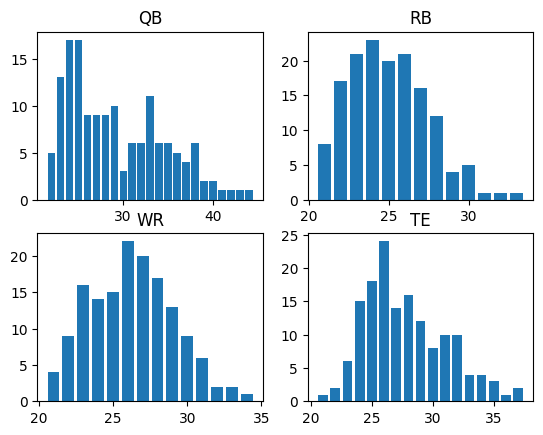

In [32]:
plot = 1
for pos in positions:
    plt.subplot(2,2,plot)
    plot += 1
    print(list(age_counts[pos].keys()), list(age_counts[pos].values()))
    plt.bar(age_counts[pos].keys(), age_counts[pos].values())
    plt.title(pos)

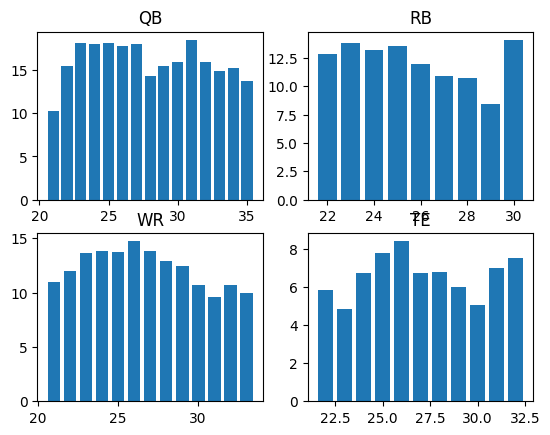

In [33]:
plot = 1
for pos in positions:
    plt.subplot(2,2,plot)
    plot += 1
    plt.bar(ppr_ages[pos].keys(), ppr_ages[pos].values())
    plt.title(pos)

In [34]:
vbd = None
mutilplier = 2
for i in range(year-1, year-4, -1):
    year_stat = stats[i][['G', 'VBD']]
    year_stat['G'] = year_stat['G'].astype(int)
    year_stat['VBD'] = year_stat['VBD'].astype(float)
    if type(vbd) != pd.DataFrame:
        vbd = year_stat
    else:
        if i == year-2:

            #keep players that have played in the fast two years
            vbd = vbd.merge(year_stat, how="outer", on="Player")
        else:
            #assume player doesn't play anymore if not in most recent 2 years of data
            vbd = vbd.merge(year_stat, how="left", on="Player")

        vbd.fillna(0, inplace= True)
        vbd['G'] = vbd['G_x'] * mutilplier + vbd['G_y']
        vbd['VBD'] = vbd['VBD_x'] * mutilplier + vbd['VBD_y']

        vbd.drop(['G_x', 'G_y', 'VBD_x', 'VBD_y'], axis=1, inplace=True)
        

vbd['Weighted_VBD'] = vbd['VBD'] / vbd['G']



/var/folders/4k/xb9s62bj17d5cs3n4n0h4np40000gn/T/ipykernel_10356/1418025355.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_stat['G'] = year_stat['G'].astype(int)
/var/folders/4k/xb9s62bj17d5cs3n4n0h4np40000gn/T/ipykernel_10356/1418025355.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_stat['VBD'] = year_stat['VBD'].astype(float)
/var/folders/4k/xb9s62bj17d5cs3n4n0h4np40000gn/T/ipykernel_10356/1418025355.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

In [35]:
vbd = vbd.merge(stats[year-1][['Age', 'FantPos']], on="Player", how="left")
vbd = vbd.merge(stats[year-2][['Age', 'FantPos']], on="Player", how="left", suffixes=('','_backup'))
vbd["Age_backup"] = vbd["Age_backup"].fillna(0).astype(int) + 1
vbd["Age"].fillna(vbd["Age_backup"], inplace=True)
vbd["Age"] = vbd["Age"].astype(int) + 1
vbd['FantPos'].fillna(vbd['FantPos_backup'], inplace=True)
vbd.drop(["Age_backup", "FantPos_backup"], inplace=True, axis=1)
vbd = vbd[vbd['FantPos'].isin(positions)]


In [36]:
peaks = {
    'RB' : 25,
    'WR' : 26,
    'TE' : 26,
    'QB' : (22, 32)
}

def age_adjust(pos, age, VBD):
    limit = peaks[pos]
    if pos != 'QB':
        if age < limit:
            return VBD * 1.05
        elif age > limit + 3:
            return VBD * 0.9
        elif age > limit + 1:
            return VBD * 0.95
        else:
            return VBD
    else:
        if age <= limit[0]:
            return VBD * 1.05
        elif age > limit[1]:
            return VBD * 0.95
        else:
            return VBD

vbd['Adjusted_VBD'] = vbd.apply(lambda row: age_adjust(row["FantPos"], row["Age"], row["Weighted_VBD"]), axis=1)
vbd.sort_values(by="Adjusted_VBD", inplace=True, ascending=False)
vbd['Rank'] = np.arange(1, vbd.shape[0] + 1)

In [37]:
vbd.head(10)
vbd_header = vbd[['Rank', 'FantPos', 'Age', 'Weighted_VBD']].head(20)
vbd_header.reset_index(inplace=True)
vbd_header = vbd_header.set_index(['Rank'])
vbd_header.to_csv('vbd.csv', quoting=csv.QUOTE_NONNUMERIC, quotechar="'")

In [38]:
rankings = pd.read_csv('FPRankings.csv', index_col="Player")


vbd = vbd.merge(rankings[['RK', 'POS', 'TM', 'BYE WEEK']], how="right", on="Player")

vbd.rename(columns={'RK': 'ECR',},
          inplace=True, errors='raise')
vbd.drop('FantPos', inplace=True, axis=1)
vbd.fillna(0, inplace=True)

vbd

,G,VBD,Weighted_VBD,Age,Adjusted_VBD,Rank,ECR,POS,TM,BYE WEEK
Player,,,,,,,,,,
Christian McCaffrey,105.0,874.0,8.323810,28.0,7.907619,1.0,1,RB,SF,9
CeeDee Lamb,118.0,704.0,5.966102,25.0,6.264407,3.0,2,WR,DAL,7
Tyreek Hill,115.0,754.0,6.556522,30.0,5.900870,4.0,3,WR,MIA,6
Amon-Ra St. Brown,113.0,415.0,3.672566,25.0,3.856195,10.0,4,WR,DET,5
Ja'Marr Chase,105.0,296.0,2.819048,24.0,2.960000,24.0,5,WR,CIN,12
...,...,...,...,...,...,...,...,...,...,...
Dallin Holker,0.0,0.0,0.000000,0.0,0.000000,0.0,494,TE,NO,12
Jimmy Garoppolo,65.0,0.0,0.000000,33.0,0.000000,590.0,495,QB,LAR,6
Anthony Gould,0.0,0.0,0.000000,0.0,0.000000,0.0,496,WR,IND,14


In [39]:
def expert_adjust(rank, ecr):
    if rank == 0:
        return ecr
    else:
        if abs(rank - ecr) >= 15:
            return round((rank + 2 * ecr) / 3,2)
        else:
            return round((2 * rank + ecr) / 3,2)


vbd['Composite Score'] = vbd.apply(lambda row: expert_adjust(row["Rank"], row["ECR"]), axis=1)
vbd.sort_values(by="Composite Score", inplace=True)
vbd['Composite Rank'] = np.arange(1, vbd.shape[0] + 1)
vbd['Vs. Expert'] = vbd['ECR'] - vbd['Composite Rank']
vbd['Age'] = vbd['Age'].astype(int)

vbd.head(20)

,G,VBD,Weighted_VBD,Age,Adjusted_VBD,Rank,ECR,POS,TM,BYE WEEK,Composite Score,Composite Rank,Vs. Expert
Player,,,,,,,,,,,,,
Christian McCaffrey,105.0,874.0,8.323810,28,7.907619,1.0,1,RB,SF,9,1.00,1,0
CeeDee Lamb,118.0,704.0,5.966102,25,6.264407,3.0,2,WR,DAL,7,2.67,2,0
Tyreek Hill,115.0,754.0,6.556522,30,5.900870,4.0,3,WR,MIA,6,3.67,3,0
Justin Jefferson,91.0,353.0,3.879121,25,4.073077,8.0,6,WR,MIN,6,7.33,4,2
Amon-Ra St. Brown,113.0,415.0,3.672566,25,3.856195,10.0,4,WR,DET,5,8.00,5,-1
Ja'Marr Chase,105.0,296.0,2.819048,24,2.960000,24.0,5,WR,CIN,12,11.33,6,-1
Puka Nacua,68.0,240.0,3.529412,23,3.705882,14.0,11,WR,LAR,6,13.00,7,4
Josh Allen,117.0,848.0,7.247863,28,7.247863,2.0,19,QB,BUF,12,13.33,8,11
A.J. Brown,115.0,386.0,3.356522,27,3.356522,16.0,9,WR,PHI,5,13.67,9,0


In [40]:
df = vbd[['POS', 'TM', 'Age', 'Composite Rank', 'ECR', 'Vs. Expert', 'BYE WEEK']]
df.to_csv('CompositeRanking.csv')